Using multiple OLPS models + GMA model selector was our strategy for the spot market so far. 

But after various experimentations, I realised that simply using Uniform Buy and Hold (BAH) or Uniform Constantly Rebalanced Portfolio (CRP) is enough to generate profits in the long run. We will go with Uniform BAH since Uniform CRP incurs commissions that could negatively impact gains in the long run. 

However, we still need a mechansim to defend against bearish markets when we are trading in the spot market. We can do this by converting our asset to cash during the down market (henceforth denoted as "converting to the cash agent"). 

We now need to be able fine tune our GMA model selector such that it can make clever decisions regarding when to convert to cash agent and when to invest again. It would be better if this was an RL agent operating on a neural network, but we will deal with that later. For now, we simply tune our GMA model selector.

We mostly selected cryptocurrencies related to NFT, Web3.0 and the Metaverse.

In [294]:
import numpy as np 
import pandas as pd
import json 
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import datetime
import ccxt 
from cvxopt import matrix, solvers
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
import tensorflow.keras.backend as K

# Preprocess Dataset

In [3]:
btc = pd.read_json('BTC_USDT-1h.json')
eth = pd.read_json('ETH_USDT-1h.json')
dot = pd.read_json('DOT_USDT-1h.json') 
link = pd.read_json('LINK_USDT-1h.json')
luna = pd.read_json('LUNA_USDT-1h.json') 
mana = pd.read_json('MANA_USDT-1h.json') 
matic = pd.read_json('MATIC_USDT-1h.json') 
sand = pd.read_json('SAND_USDT-1h.json')
sol = pd.read_json('SOL_USDT-1h.json')

In [4]:
# get date time info for each dataframe. 
def create_timestamp(df, interval=10): 
    dates = df[0].values 
    binance = ccxt.binance() 
    timestamp = [] 
    for i in range(len(dates)): 
        date_string = binance.iso8601(int(dates[i]))  
        date_string = date_string[:10] + " " + date_string[11:-5] 
        timestamp.append(date_string) 

    df['timestamp'] = timestamp
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.iloc[::interval,[6,4]]  
    df = df.rename(columns={4:'close', 'timestamp':'datetime'}) 
    return df

In [5]:
btc = create_timestamp(btc)
eth = create_timestamp(eth)
dot = create_timestamp(dot) 
link = create_timestamp(link) 
luna = create_timestamp(luna) 
mana = create_timestamp(mana) 
matic = create_timestamp(matic) 
sand = create_timestamp(sand) 
sol = create_timestamp(sol)

In [6]:
btc.tail()

,datetime,close
9270,2022-01-22 19:00:00,34528.62
9280,2022-01-23 05:00:00,35456.40
9290,2022-01-23 15:00:00,35287.58
9300,2022-01-24 01:00:00,35652.22
9310,2022-01-24 11:00:00,33697.11


In [7]:
luna.head()

,datetime,close
0,2021-01-01 00:00:00,0.6569
10,2021-01-01 10:00:00,0.6443
20,2021-01-01 20:00:00,0.6346
30,2021-01-02 06:00:00,0.6332
40,2021-01-02 16:00:00,0.6290


In [8]:
price_data = np.concatenate([btc['close'].values.reshape((-1,1)),
                             eth['close'].values.reshape((-1,1)),
                             dot['close'].values.reshape((-1,1)),
                             link['close'].values.reshape((-1,1)),
                             luna['close'].values.reshape((-1,1)),
                             mana['close'].values.reshape((-1,1)),
                             matic['close'].values.reshape((-1,1)),
                             sand['close'].values.reshape((-1,1)),
                             sol['close'].values.reshape((-1,1))], axis=1) 

price_data.shape

(932, 9)

# Define variables

In [265]:
gamma = 0.1 # commissions, 0.05% for upbit spot trading so we double it for our backtests 
init_seed = 1000 # assume we start with $1000 
threshold = 0.005 # for deciding if it's the right timing to invest 
m = price_data.shape[1] # number of assets in our portfolio
w = 5 # window size for OLMAR and other Mean Reversion Models  

# BTC BAH

In [389]:
btc_bah_portfolio = [1,0,0,0,0,0,0,0,0] 
btc_bah_cash_status = [init_seed]
btc_realized_returns = [] 
cash = init_seed 

for i in tqdm(range(w-1, price_data.shape[0])): 
    if i > w-1: 
        # hold 
        current_returns = []
        for j in range(m): 
            ret = price_data[i,j] / price_data[i-1,j] 
            current_returns.append(ret) 
        cash = np.sum([btc_bah_portfolio[j]*cash*current_returns[j] for j in range(m)]) 
        btc_bah_cash_status.append(cash)
        btc_realized_returns.append(np.sum([x*y for x,y in zip(btc_bah_portfolio, current_returns)]))
    
    # buy 
    if i == w-1: 
        cash = np.sum([btc_bah_portfolio[j]*cash*(1-gamma/100) for j in range(m)])
    
print("final cash amount = ${:.2f}".format(cash)) 
print("percentage profit = {:.2f}%".format((cash-init_seed)/init_seed * 100))


100%|██████████| 928/928 [00:00<00:00, 24649.41it/s]

final cash amount = $1036.36
percentage profit = 3.64%


In [390]:
MDD(btc_bah_cash_status)

MDD = -53.73%


# Uniform BAH

In [383]:
uniform_bah_portfolio = [1/m for _ in range(m)] 
uniform_bah_cash_status = [init_seed]
cash = init_seed 

for i in tqdm(range(w-1, price_data.shape[0]), position=0, leave=True): 
    if i > w-1: 
        # hold
        current_returns = []
        for j in range(m): 
            ret = price_data[i,j] / price_data[i-1,j] 
            current_returns.append(ret)
        cash = np.sum([uniform_bah_portfolio[j]*cash*current_returns[j] for j in range(m)]) 
        uniform_bah_cash_status.append(cash) 
    
    # buy 
    if i == w-1: 
        cash = np.sum([uniform_bah_portfolio[j]*cash*(1-gamma/100) for j in range(m)]) 
        
print("final cash amount = ${:.2f}".format(cash)) 
print("percentage profit = {:.2f}%".format((cash-init_seed)/init_seed * 100))

100%|██████████| 928/928 [00:00<00:00, 48282.15it/s]

final cash amount = $22105.78
percentage profit = 2110.58%


In [385]:
MDD(uniform_bah_cash_status)

MDD = -54.44%


# Exponential Gradient

In [380]:
def exponential_gradient(current_portfolio, current_returns, eta=0.05): 
    current_portfolio = np.asarray(current_portfolio)
    current_returns = np.asarray(current_returns)
    new_portfolio = current_portfolio * np.exp(eta * current_returns / sum(current_returns * current_portfolio))
    return new_portfolio / sum(new_portfolio)

In [381]:
eg_portfolio = [1/m for _ in range(m)]
eg_cash_status = [init_seed]
cash = init_seed 

for i in tqdm(range(w-1, price_data.shape[0]), position=0, leave=True): 
    # calculate current returns 
    current_returns = []
    for j in range(m): 
        ret = price_data[i,j] / price_data[i-1,j] 
        current_returns.append(ret)
    
    if i > w-1: 
        # sell
        cash = np.sum([eg_portfolio[j]*cash*current_returns[j]*(1-gamma/100) for j in range(m)]) 
        eg_cash_status.append(cash) 
    
    eg_portfolio = exponential_gradient(eg_portfolio, current_returns)
    # buy 
    cash = np.sum([eg_portfolio[j]*cash*(1-gamma/100) for j in range(m)]) 
    
        
print("final cash amount = ${:.2f}".format(cash)) 
print("percentage profit = {:.2f}%".format((cash-init_seed)/init_seed * 100))

100%|██████████| 928/928 [00:00<00:00, 11512.21it/s]

final cash amount = $3733.32
percentage profit = 273.33%


In [382]:
MDD(eg_cash_status)

MDD = -65.89%


# OLMAR 

In [208]:
# simplex projection 
def simplex_proj(y):
    """ Projection of y onto simplex. """
    m = len(y)
    bget = False
    s = sorted(y, reverse=True)
    tmpsum = 0.
    for ii in range(m-1):
        tmpsum = tmpsum + s[ii]
        tmax = (tmpsum - 1) / (ii + 1);
        if tmax >= s[ii+1]:
            bget = True
            break
    if not bget:
        tmax = (tmpsum + s[m-1] -1)/m
    y = np.asarray(y)
    return np.maximum(y-tmax,0.)


def OLMAR(current_portfolio, predicted_returns, epsilon=10):
    avg_x = np.sum([x*y for x,y in zip([1 for i in predicted_returns], predicted_returns)])
    avg_x *= 1.0 / float(len(predicted_returns))
    # numerator
    temp_top = epsilon - sum([x*y for x,y in zip(current_portfolio, predicted_returns)])
    # denominator
    temp_bottom1 = np.array(predicted_returns)
    temp_bottom2 = np.array([avg_x for i in predicted_returns])
    dist = np.sum(np.power((temp_bottom1 - temp_bottom2), 2))
    lambda_1 = max(0.0, temp_top/dist)
    # update portfolio
    np_current_portfolio = np.array(current_portfolio)
    new_portfolio = np_current_portfolio + lambda_1 * (temp_bottom1 - temp_bottom2)
    new_portfolio = simplex_proj(new_portfolio.tolist())
    return new_portfolio 

In [377]:
olmar_portfolio = [1/m for _ in range(m)]
olmar_cash_status = [init_seed]
olmar_realized_returns = [] 
cash = init_seed 

for i in tqdm(range(w-1, price_data.shape[0]), position=0, leave=True): 
    # calculate current returns 
    current_returns = []
    for j in range(m): 
        ret = price_data[i,j] / price_data[i-1,j] 
        current_returns.append(ret)
        
    # next price prediction using moving average  
    predicted_returns = [] 
    for j in range(m): 
        moving_avg = np.mean(price_data[i-w+1:i+1,j]) 
        ret = moving_avg/price_data[i,j] 
        predicted_returns.append(ret) 
    
    if i > w-1: 
        # sell
        cash = np.sum([eg_portfolio[j]*cash*current_returns[j]*(1-gamma/100) for j in range(m)]) 
        olmar_cash_status.append(cash) 
        olmar_realized_returns.append(np.sum([x*y for x,y in zip(olmar_portfolio, current_returns)]))
    
    olmar_portfolio = OLMAR(olmar_portfolio, predicted_returns)
    # buy 
    cash = np.sum([olmar_portfolio[j]*cash*(1-gamma/100) for j in range(m)]) 
    
        
print("final cash amount = ${:.2f}".format(cash)) 
print("percentage profit = {:.2f}%".format((cash-init_seed)/init_seed * 100))

100%|██████████| 928/928 [00:00<00:00, 2810.35it/s]

final cash amount = $4345.52
percentage profit = 334.55%


In [378]:
sharpe_ratio(olmar_realized_returns)

sharpe ratio = 19.73


In [379]:
MDD(olmar_cash_status)

MDD = -65.33%


# Transaction Cost Optimization

In [249]:
def tco(x, current_portfolio, x_pred, trx_fee_pct=gamma, eta=10): 
    lambd = 10 * trx_fee_pct
    updated_portfolio = np.multiply(current_portfolio, x) / np.dot(current_portfolio, x) 
    vt = x_pred / np.dot(updated_portfolio, x_pred) 
    v_t_ = np.mean(vt) 
    b_1 = eta * (vt - np.dot(v_t_, 1)) 
    b_ = updated_portfolio + np.sign(b_1) * np.maximum(np.zeros(len(b_1)), np.abs(b_1)-lambd) 
    proj = simplex_proj(b_) 
    return proj
    

In [374]:
tco_portfolio = [1/m for _ in range(m)]
tco_cash_status = [init_seed]
tco_realized_returns = [] 
cash = init_seed 

for i in tqdm(range(w-1, price_data.shape[0]), position=0, leave=True): 
    # calculate current returns 
    current_returns = []
    for j in range(m): 
        ret = price_data[i,j] / price_data[i-1,j] 
        current_returns.append(ret)
        
    # next price prediction using moving average  
    predicted_returns = [] 
    for j in range(m): 
        moving_avg = np.mean(price_data[i-w+1:i+1,j]) 
        ret = moving_avg/price_data[i,j] 
        predicted_returns.append(ret) 
    
    if i > w-1: 
        # sell
        cash = np.sum([tco_portfolio[j]*cash*current_returns[j]*(1-gamma/100) for j in range(m)]) 
        tco_cash_status.append(cash) 
        tco_realized_returns.append(np.sum([x*y for x,y in zip(tco_portfolio, current_returns)]))
    
    tco_portfolio = tco(current_returns,tco_portfolio, predicted_returns)
    # buy 
    cash = np.sum([tco_portfolio[j]*cash*(1-gamma/100) for j in range(m)]) 
    
        
print("final cash amount = ${:.2f}".format(cash)) 
print("percentage profit = {:.2f}%".format((cash-init_seed)/init_seed * 100))

100%|██████████| 928/928 [00:00<00:00, 3285.22it/s]

final cash amount = $4905.41
percentage profit = 390.54%


In [376]:
MDD(tco_cash_status)

MDD = -65.54%


# PAMR

In [224]:
def PAMR(current_portfolio, x, epsilon=0.5, C=500, variant=0): 
    x_mean = np.mean(x) 
    le = max(0.0, np.dot(current_portfolio, x) - epsilon)
    if variant==0:
        lam = le / np.linalg.norm(x - x_mean) ** 2 
    elif variant==1:
        lam = min(C, le / np.linalg.norm(x - x_mean) ** 2) 
    elif variant==2: 
        lam = le / (np.linalg.norm(x - x_mean)**2 + 0.5 / C) 
    lam = min(100000,lam) 
    new_portfolio = current_portfolio - lam * (x - x_mean)
    return simplex_proj(new_portfolio) 

In [366]:
pamr_portfolio = [1/m for _ in range(m)]
pamr_cash_status = [init_seed]
pamr_realized_returns = [] 
cash = init_seed 

for i in tqdm(range(w-1, price_data.shape[0]), position=0, leave=True): 
    # calculate current returns 
    current_returns = []
    for j in range(m): 
        ret = price_data[i,j] / price_data[i-1,j] 
        current_returns.append(ret)
    
    if i > w-1: 
        # sell
        cash = np.sum([pamr_portfolio[j]*cash*current_returns[j]*(1-gamma/100) for j in range(m)]) 
        pamr_cash_status.append(cash) 
        pamr_realized_returns.append(np.sum([x*y for x,y in zip(pamr_portfolio, current_returns)]))
    
    pamr_portfolio = PAMR(pamr_portfolio, current_returns)
    # buy 
    cash = np.sum([pamr_portfolio[j]*cash*(1-gamma/100) for j in range(m)]) 
    
        
print("final cash amount = ${:.2f}".format(cash)) 
print("percentage profit = {:.2f}%".format((cash-init_seed)/init_seed * 100))

100%|██████████| 928/928 [00:00<00:00, 4452.46it/s]

final cash amount = $1974.97
percentage profit = 97.50%


In [372]:
def MDD(arr): 
    mdd = 1e9
    for i in range(len(arr)): 
        for j in range(i+1, len(arr)): 
            x1 = arr[i]
            x2 = arr[j] 
            if x2 < x1: 
                curval = (x2-x1)/x1 * 100 
                if curval < mdd: 
                    mdd = curval
    print("MDD = {:.2f}%".format(mdd))
    
MDD(pamr_cash_status)

MDD = -68.94%


# Vanilla LSTM

In [289]:
class LSTM_MODEL:
    def __init__(self):
        self.data = None
        self.model = None
    
    def __build_model(self, input_shape, outputs):
        model = Sequential(
            [
                LSTM(64, input_shape=input_shape),
                Flatten(),
                Dense(outputs, activation="softmax"),
            ]
        )

        def sharpe_loss(_, y_pred):
            # make all time-series start at 1
            data = tf.divide(self.data, self.data[0])

            # value of the portfolio after allocations applied
            portfolio_values = tf.reduce_sum(tf.multiply(data, y_pred), axis=1)

            portfolio_returns = (
                portfolio_values[1:] - portfolio_values[:-1]
            ) / portfolio_values[:-1]  # % change formula

            sharpe = K.mean(portfolio_returns) / K.std(portfolio_returns)
            # since we want to maximize Sharpe, while gradient descent minimizes the loss,
            #   we can negate Sharpe (the min of a negated function is its max)
            return -sharpe
        model.compile(loss=sharpe_loss, optimizer="adam")
        return model
    
    def get_allocations(self, data: pd.DataFrame):
        """
        Computes and returns the allocation ratios that optimize the Sharpe over the given data
        input: data - DataFrame of historical closing prices of various assets
        return: the allocations ratios for each of the given assets
        """

        # data with returns
        data_w_ret = np.concatenate(
            [data.values[1:], data.pct_change().values[1:]], axis=1
        )

        data = data.iloc[1:]
        self.data = tf.cast(tf.constant(data), float)

        if self.model is None:
            self.model = self.__build_model(data_w_ret.shape, len(data.columns))

        fit_predict_data = data_w_ret[np.newaxis, :]
        self.model.fit(
            fit_predict_data, np.zeros((1, len(data.columns))), epochs=20, shuffle=False, verbose=0
        )
        return self.model.predict(fit_predict_data)[0]

In [290]:
class LSTM_REBALANCER:
    def __init__(self, m):
        self.m = m
        self.model = LSTM_MODEL()

    def predict(self, current_portfolio, df):
        return self.model.get_allocations(df)

In [291]:
# we use dataframe for the LSTM Rebalancer 
price_df = pd.DataFrame(price_data) 
price_df.head()

,0,1,2,3,4,5,6,7,8
0,28995.13,734.07,9.2609,11.2812,0.6569,0.08260,0.01782,0.036285,1.5442
1,29223.82,736.81,8.8827,11.4697,0.6443,0.08161,0.01811,0.036885,1.6330
2,29200.96,729.48,8.3265,11.9257,0.6346,0.08148,0.01762,0.036267,1.7686
3,29709.07,737.04,8.4097,11.6586,0.6332,0.07981,0.01858,0.038027,1.7661
4,32482.28,781.94,9.3668,12.2492,0.6290,0.07838,0.01815,0.038050,1.8011


In [362]:
lstm = LSTM_REBALANCER(m) 
lstm_portfolio = [1/m for _ in range(m)]
lstm_realized_returns = [] 
lstm_cash_status = [init_seed]
cash = init_seed 

for i in tqdm(range(w-1, price_df.shape[0]), position=0, leave=True): 
    # calculate current returns 
    current_returns = []
    for j in range(m): 
        ret = price_data[i,j] / price_data[i-1,j] 
        current_returns.append(ret)
    
    if i > w-1: 
        # sell
        cash = np.sum([lstm_portfolio[j]*cash*current_returns[j]*(1-gamma/100) for j in range(m)]) 
        lstm_cash_status.append(cash) 
        lstm_realized_returns.append(np.sum([x*y for x,y in zip(lstm_portfolio, current_returns)]))
    
    lstm_portfolio = lstm.predict(lstm_portfolio, price_df.iloc[i-w+1:i+1]) 
    # buy 
    cash = np.sum([lstm_portfolio[j]*cash*(1-gamma/100) for j in range(m)]) 
    
        
print("final cash amount = ${:.2f}".format(cash)) 
print("percentage profit = {:.2f}%".format((cash-init_seed)/init_seed * 100))

100%|██████████| 928/928 [03:20<00:00,  4.63it/s]

final cash amount = $7740.36
percentage profit = 674.04%


In [364]:
mdd = 10000
for i in range(len(lstm_cash_status)): 
    for j in range(i+1, len(lstm_cash_status)): 
        x1 = lstm_cash_status[i]
        x2 = lstm_cash_status[j] 
        if x2 < x1: 
            curval = (x2-x1)/x1 * 100 
            if curval < mdd: 
                mdd = curval
                
print("MDD = {:.2f}%".format(mdd))

MDD = -62.43%


# Down market defense model: Defensive GMA v1.0 

In [212]:
# compute geometric mean of array x 
def geometric_mean(x):
    x = np.asarray(x) 
    return x.prod() ** (1/len(x)) 

In [213]:
def backtest(model_selector_w): 
    defensive_bah_portfolio = [1/m for _ in range(m)] 
    cash_agent = [0 for _ in range(m)]
    defensive_bah_cash_status = [init_seed] 
    defensive_bah_returns = [] 
    cash = init_seed
    window_range = 100 
    scores = np.zeros((window_range))  
    validation_step = 100 
    choice = 0 # 0: Uniform BAH, 1: Cash Agent 
    bah, ca = 0, 0 

    for i in tqdm(range(w-1, price_data.shape[0]), position=0, leave=True): 
        if i > w-1: 
            current_returns = [] 
            for j in range(m): 
                ret = price_data[i,j] / price_data[i-1,j] 
                current_returns.append(ret)

            # calculate current cash balance 
            if choice == 0: 
                cash = np.sum([defensive_bah_portfolio[j]*cash*current_returns[j] for j in range(m)]) 
            elif choice == 1: 
                pass

            defensive_bah_returns.append(np.sum([x*y for x,y in zip(defensive_bah_portfolio, current_returns)]))
            if len(defensive_bah_returns) > model_selector_w: 
                defensive_bah_returns.pop(0)

            defensive_bah_cash_status.append(cash) 


        if i == w-1: 
            # buy 
            # default for first trade is uniform BAH 
            bah += 1 
            choice = 0 
            cash = np.sum([defensive_bah_portfolio[j]*cash*(1-gamma/100) for j in range(m)]) 


        elif i > w-1:                    
            gma_profits = geometric_mean(defensive_bah_returns)

            if gma_profits > 1 + threshold: 
                bah += 1 
                if choice == 1: 
                    cash = np.sum([defensive_bah_portfolio[j]*cash*(1-gamma/100) for j in range(m)]) 
                choice = 0 
            else: 
                ca += 1 
                if choice == 0: 
                    cash = np.sum([defensive_bah_portfolio[j]*cash*(1-gamma/100) for j in range(m)]) 
                choice = 1
    
    plt.plot(defensive_bah_cash_status)
    return cash

100%|██████████| 928/928 [00:00<00:00, 27386.75it/s]


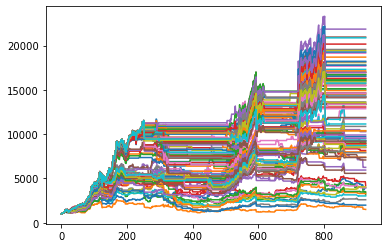

In [214]:
res = [] 
for i in range(1,101): 
    res.append((i, backtest(i)))

In [215]:
res.sort(key=lambda x:x[1])

In [216]:
res[::-1][:10]

[(85, 21853.614484341357),
 (76, 20958.090257642423),
 (80, 20869.428975310286),
 (74, 20163.465151289623),
 (78, 19555.60461271966),
 (79, 19418.75661420467),
 (81, 19263.01328353179),
 (77, 19143.34742451108),
 (82, 18692.62772160949),
 (91, 18217.966967162698)]

Just a rough simulation shows that window size of 85 is the best. 

Typically a window size of 72-96 seems reasonable. i.e. we need an accumulation of at least a month of data in order to have an idea of whether the market is an upmarket or a downmarket. 

For a more robust parameter tuning process, we can test the performance of various parameters on other years (e.g. from years 2016-2020). For now, let's just take 85 as our parameter. 

In [358]:
defensive_bah_portfolio = [1/m for _ in range(m)] 
cash_agent = [0 for _ in range(m)]
defensive_bah_cash_status = [init_seed] 
defensive_bah_returns = [] 
defensive_bah_realized_returns = []
cash = init_seed
window_range = 100 
scores = np.zeros((window_range))  
validation_step = 100 
choice = 0 # 0: Uniform BAH, 1: Cash Agent 
bah, ca = 0, 0 
model_selector_w = 85

for i in tqdm(range(w-1, price_data.shape[0]), position=0, leave=True): 
    if i > w-1: 
        current_returns = [] 
        for j in range(m): 
            ret = price_data[i,j] / price_data[i-1,j] 
            current_returns.append(ret)

        # calculate current cash balance 
        if choice == 0: 
            cash = np.sum([defensive_bah_portfolio[j]*cash*current_returns[j] for j in range(m)]) 
        elif choice == 1: 
            pass

        defensive_bah_returns.append(np.sum([x*y for x,y in zip(defensive_bah_portfolio, current_returns)]))
        if len(defensive_bah_returns) > model_selector_w: 
            defensive_bah_returns.pop(0)

        defensive_bah_cash_status.append(cash) 
        
        if choice == 0: 
            defensive_bah_realized_returns.append(np.sum([x*y for x,y in zip(defensive_bah_portfolio, current_returns)]))
        elif choice == 1: 
            defensive_bah_realized_returns.append(1.0)


    if i == w-1: 
        # buy 
        # default for first trade is uniform BAH 
        bah += 1 
        choice = 0 
        cash = np.sum([defensive_bah_portfolio[j]*cash*(1-gamma/100) for j in range(m)]) 


    elif i > w-1:                    
        gma_profits = geometric_mean(defensive_bah_returns)

        if gma_profits > 1 + threshold: 
            bah += 1 
            if choice == 1: 
                cash = np.sum([defensive_bah_portfolio[j]*cash*(1-gamma/100) for j in range(m)]) 
            choice = 0 
        else: 
            ca += 1 
            if choice == 0: 
                cash = np.sum([defensive_bah_portfolio[j]*cash*(1-gamma/100) for j in range(m)]) 
            choice = 1
    
print("final cash amount = ${:.2f}".format(cash))
print("percentage profit = {:.2f}%".format((cash-init_seed)/init_seed * 100))

100%|██████████| 928/928 [00:00<00:00, 10111.80it/s]

final cash amount = $21853.61
percentage profit = 2085.36%


In [359]:
bah, ca

(420, 508)

In [361]:
mdd = 10000
for i in range(len(defensive_bah_cash_status)): 
    for j in range(i+1, len(defensive_bah_cash_status)): 
        x1 = defensive_bah_cash_status[i]
        x2 = defensive_bah_cash_status[j] 
        if x2 < x1: 
            curval = (x2-x1)/x1 * 100 
            if curval < mdd: 
                mdd = curval
                
print("MDD = {:.2f}%".format(mdd))

MDD = -21.28%


# Defensive GMA v2.0

In [336]:
defensive_bah_portfolio = [1/m for _ in range(m)] 
defensive_tco_portfolio = [1/m for _ in range(m)] 
cash_agent = [0 for _ in range(m)]
defensive_cash_status = [init_seed] 
defensive_bah_returns = [] 
defensive_tco_returns = [] 
realized_returns = []
cash = init_seed
choice = 0 # 0: Uniform BAH, 1: Cash Agent, 2: TCO 
bah, ca, tco_cnt = 0, 0, 0
model_selector_w = 85

for i in tqdm(range(w-1, price_data.shape[0]), position=0, leave=True): 
    # calculate current returns 
    current_returns = [] 
    for j in range(m): 
        ret = price_data[i,j] / price_data[i-1,j] 
        current_returns.append(ret)

    # next price prediction using moving average  
    predicted_returns = [] 
    for j in range(m): 
        moving_avg = np.mean(price_data[i-w+1:i+1,j]) 
        ret = moving_avg/price_data[i,j] 
        predicted_returns.append(ret) 
    
    if i > w-1: 
        # calculate current cash balance 
        if choice == 0: 
            cash = np.sum([defensive_bah_portfolio[j]*cash*current_returns[j] for j in range(m)]) 
        elif choice == 1: 
            pass
        elif choice == 2: 
            cash = np.sum([defensive_tco_portfolio[j]*cash*current_returns[j]*(1-gamma/100) for j in range(m)])

        defensive_bah_returns.append(np.sum([x*y for x,y in zip(defensive_bah_portfolio, current_returns)]))
        if len(defensive_bah_returns) > model_selector_w: 
            defensive_bah_returns.pop(0)

        defensive_tco_returns.append(np.sum([x*y for x,y in zip(defensive_tco_portfolio, current_returns)])) 
        if len(defensive_tco_returns) > model_selector_w: 
            defensive_tco_returns.pop(0) 
            
        # store realized returns 
        if choice == 0: 
            realized_returns.append(np.sum([x*y for x,y in zip(defensive_bah_portfolio, current_returns)]))
        if choice == 1: 
            realized_returns.append(1.0) 
        elif choice == 2: 
            realized_returns.append(np.sum([x*y for x,y in zip(defensive_tco_portfolio, current_returns)])) 
            
        defensive_cash_status.append(cash) 


    if i == w-1: 
        # buy 
        # default for first trade is uniform BAH 
        bah += 1 
        choice = 0 
        cash = np.sum([defensive_bah_portfolio[j]*cash*(1-gamma/100) for j in range(m)]) 
        # update tco portfolio 
        defensive_tco_portfolio = tco(current_returns,defensive_tco_portfolio, predicted_returns)
    
    elif i > w-1:                    
        # update tco portfolio 
        defensive_tco_portfolio = tco(current_returns, defensive_tco_portfolio, predicted_returns) 
        
        gma_profits_bah = geometric_mean(defensive_bah_returns)
        gma_profits_tco = geometric_mean(defensive_tco_returns)
        
        best_profits = gma_profits_bah if gma_profits_bah > gma_profits_tco else gma_profits_tco 
        best_choice = 0 if gma_profits_bah > gma_profits_tco else 2 
            
        if best_profits > 1 + threshold: 
            bah += (best_choice==0) 
            tco_cnt += (best_choice==2)
            if choice == 1: 
                best_portfolio = (defensive_bah_portfolio if best_choice == 0 else defensive_tco_portfolio)
                cash = np.sum([best_portfolio[j]*cash*(1-gamma/100) for j in range(m)]) 
            choice = best_choice 
        else: 
            ca += 1 
            if choice == 0: 
                cash = np.sum([defensive_bah_portfolio[j]*cash*(1-gamma/100) for j in range(m)])
            elif choice == 2: 
                cash = np.sum([defensive_tco_portfolio[j]*cash*(1-gamma/100) for j in range(m)]) 
            choice = 1
    
print("final cash amount = ${:.2f}".format(cash))
print("percentage profit = {:.2f}%".format((cash-init_seed)/init_seed * 100))

100%|██████████| 928/928 [00:00<00:00, 1919.12it/s]

final cash amount = $27858.56
percentage profit = 2685.86%


([<matplotlib.patches.Wedge at 0x7fe197191220>,
 [Text(-0.014895112412213604, 1.0998991479341311, 'CASH AGENT'),
  Text(-0.8868442367026795, -0.6507743847350186, 'MODEL1'),
  Text(0.6387060353676002, -0.8955750110320196, 'MODEL2')])

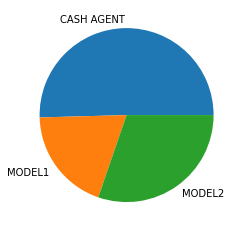

In [337]:
plt.pie([ca, bah, tco_cnt], labels=["CASH AGENT", "MODEL1", "MODEL2"])

In [348]:
mdd = 10000
for i in range(len(defensive_cash_status)): 
    for j in range(i+1, len(defensive_cash_status)): 
        x1 = defensive_cash_status[i]
        x2 = defensive_cash_status[j] 
        if x2 < x1: 
            curval = (x2-x1)/x1 * 100 
            if curval < mdd: 
                mdd = curval
                
print("MDD = {:.2f}%".format(mdd))

MDD = -21.59%


# Wealth Achieved

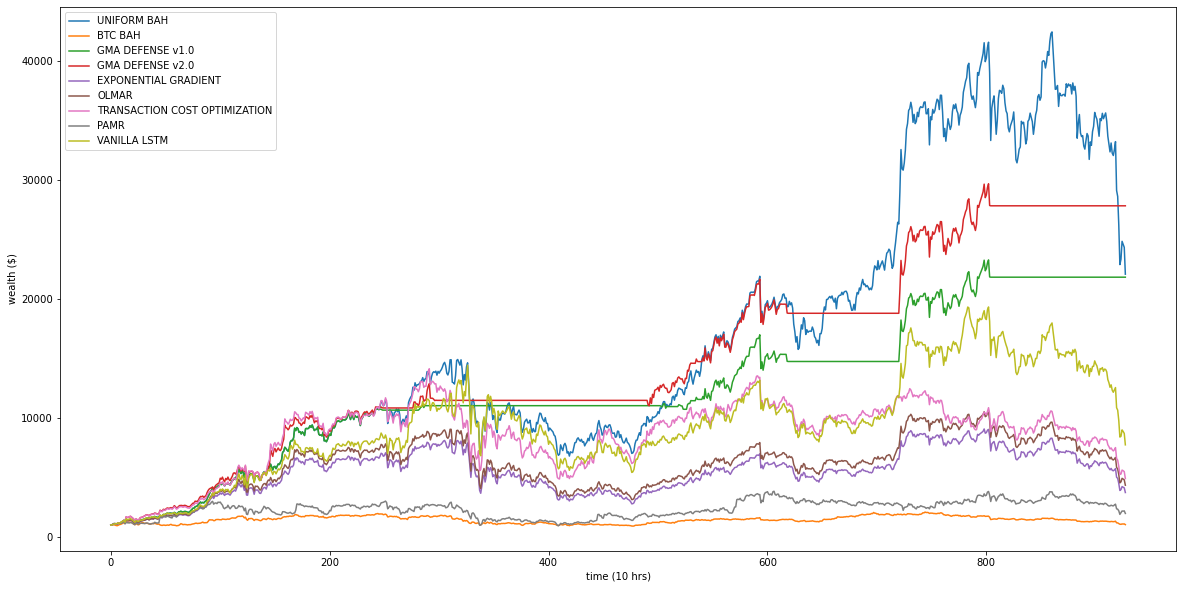

In [365]:
plt.figure(figsize=(20,10))
plt.plot(uniform_bah_cash_status, label="UNIFORM BAH")
plt.plot(btc_bah_cash_status, label="BTC BAH")
plt.plot(defensive_bah_cash_status, label="GMA DEFENSE v1.0")
plt.plot(defensive_cash_status, label="GMA DEFENSE v2.0")
plt.plot(eg_cash_status, label="EXPONENTIAL GRADIENT")
plt.plot(olmar_cash_status, label="OLMAR")
plt.plot(tco_cash_status, label="TRANSACTION COST OPTIMIZATION")
plt.plot(pamr_cash_status, label="PAMR") 
plt.plot(lstm_cash_status, label="VANILLA LSTM")
plt.xlabel("time (10 hrs)")
plt.ylabel("wealth ($)")
plt.legend()